In [1]:
#importing necessary libraries for data expolaration
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates
from datetime import datetime
from sklearn import linear_model
from numpy import polyfit
import seaborn as sns

## Initial data preprocessign and exploration

In [2]:
#Preprocessing data
df = pd.read_excel('Problem_C_Data_Wordle.xlsx') #load in excel file
df = df.drop(df.columns[[0]], axis=1)  # drop the first NaN containing columns
df.columns = df.iloc[0] #rename dataframe columns to the ones in the excel
df.drop(index=0) #drop the extra first row

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
1,2022-12-31 00:00:00,560,manly,20380,1899,0,2,17,37,29,12,2
2,2022-12-30 00:00:00,559,molar,21204,1973,0,4,21,38,26,9,1
3,2022-12-29 00:00:00,558,havoc,20001,1919,0,2,16,38,30,12,2
4,2022-12-28 00:00:00,557,impel,20160,1937,0,3,21,40,25,9,1
5,2022-12-27 00:00:00,556,condo,20879,2012,0,2,17,35,29,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2022-01-11 00:00:00,206,drink,153880,3017,1,9,35,34,16,5,1
356,2022-01-10 00:00:00,205,query,107134,2242,1,4,16,30,30,17,2
357,2022-01-09 00:00:00,204,gorge,91477,1913,1,3,13,27,30,22,4
358,2022-01-08 00:00:00,203,crank,101503,1763,1,5,23,31,24,14,2


In [3]:
df.describe()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
count,360,360,360,360,360,360,360,360,360,360,360,360
unique,360,360,360,358,345,7,23,37,33,32,31,22
top,Date,Contest number,Word,36223,10343,0,2,16,35,24,9,1
freq,1,1,1,2,2,221,56,19,38,32,30,146


In [4]:
column_names = list(df.columns.values)
column_names

['Date',
 'Contest number',
 'Word',
 'Number of  reported results',
 'Number in hard mode',
 '1 try',
 '2 tries',
 '3 tries',
 '4 tries',
 '5 tries',
 '6 tries',
 '7 or more tries (X)']

## Daily reports

In [5]:
indx = df["Contest number"].to_numpy()[1:]
number_of_results = df["Number of  reported results"].to_numpy()[1:]
number_of_hard_results = df["Number in hard mode"].to_numpy()[1:]

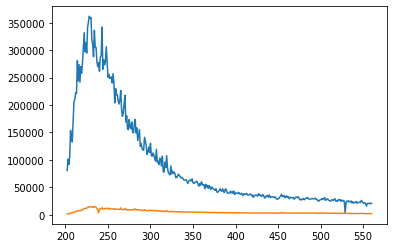

In [6]:
plt.plot(indx, number_of_results)
plt.plot(indx, number_of_hard_results)

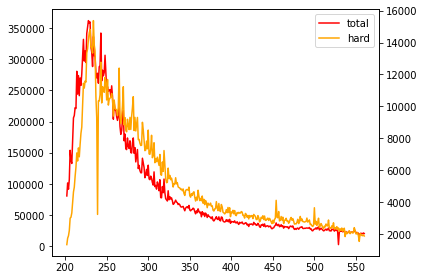

In [7]:
plt.rcParams["figure.autolayout"] = True
ax1 = plt.subplot()
l1, = ax1.plot(indx, number_of_results, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(indx, number_of_hard_results, color='orange')

plt.legend([l1, l2], ["total", "hard"])

plt.show()

### Regression on number of players

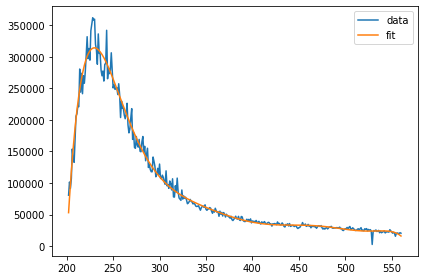

In [8]:
#Fitting using polynomial regression
poly = np.polyfit(list(indx), list(number_of_results), deg=8)

fig, ax = plt.subplots()

ax.plot(indx, number_of_results, label='data')
ax.plot(indx, np.polyval(poly, indx), label='fit')
ax.legend()

In [9]:
np.polyval(poly, 570) # very shit

-4266.3284821510315

## Difficulty distribution

In [10]:
probabilities = df[['1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)']].to_numpy()[1:]

In [11]:
# prob_dist is an (359, 7) np array of the probabilities in percent form
prob_dist = probabilities/100
# occ is an (359, 7) np array of the occurences of the number of tries for each word
occ =  (probabilities/100).T * number_of_results
occ = np.around(occ.astype(float)).T

In [12]:
#word is a np array of all of the word
words = df["Word"].to_numpy()[1:]

In [13]:
#libraries
#for NN
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import LSTM, Dense
#for word embedding
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [14]:
X_train, X_test, y_train, y_test = train_test_split(words, prob_dist, test_size=0.2, random_state=42)

### One-hot Encoding the data

In [15]:
#one hot encoding
def onehot(input_data): 

  # Define the vocabulary
  vocabulary = sorted(set("".join(input_data)))

  # Create a dictionary mapping characters to indices
  char_to_index = dict((c, i) for i, c in enumerate(vocabulary))

  # Define the maximum input length
  max_length = max(len(word) for word in input_data)

  # Encode each word using one-hot encoding
  encoded_data = np.zeros((len(input_data), max_length, len(vocabulary)), dtype=np.float32)
  for i, word in enumerate(input_data):
      for j, char in enumerate(word):
          encoded_data[i, j, char_to_index[char]] = 1.0

  return encoded_data

In [16]:
#Run onehot function here if we end up using it

### Creating word embeddings and Visualizations

In [17]:
#takes in array of words and dimension of embedding, returns embeddings
def create_word_embeddings(words, dim = 100, plot = False, highlight_last = False):
  # define the dataset
  data = [[item] for item in words]

  # train the model
  embed_model = Word2Vec(data, size=dim, window=5, min_count=1, workers=4)

  # Get the vocabulary and the corresponding embeddings
  vocab = list(embed_model.wv.vocab)
  embeddings = embed_model.wv[vocab]

  if plot == True:
    # Use t-SNE to reduce the dimensionality of the embeddings to 2D
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(words):
        x, y = embeddings_2d[i, :]
        if i != np.size(words)-1:
          plt.scatter(x, y, marker='o', color='blue') 
        else:
          if highlight_last:
            plt.scatter(x, y, marker='o', color='orange') 
          else:
            plt.scatter(x, y, marker='o', color='blue') 

        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

  return embeddings

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


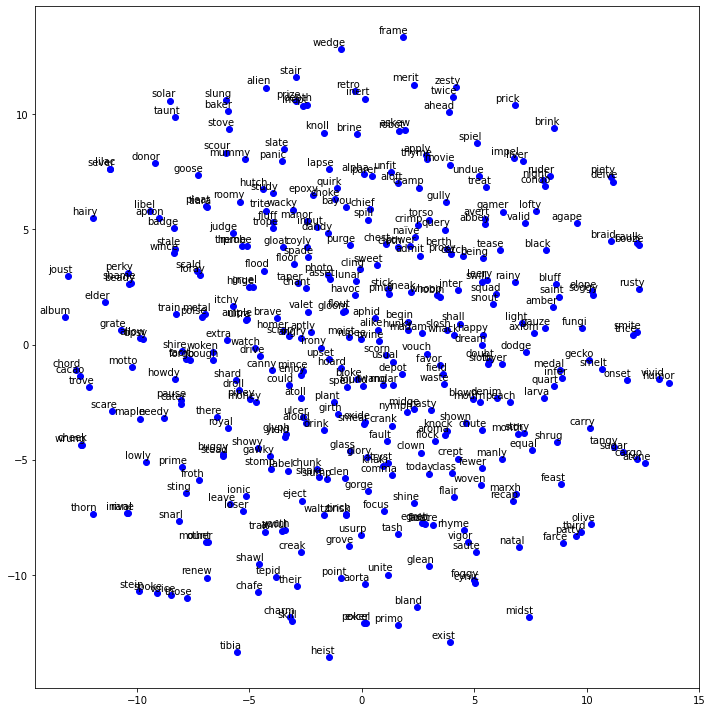

In [18]:
# Get the vocabulary and the corresponding embeddings
embeddings = create_word_embeddings(words, 100, True)

### Neural Network Approach

In [19]:

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu', input_shape=(embeddings.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with appropriate loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(embeddings, prob_dist, test_size=0.2, random_state=42)

X_train=np.asarray(X_train).astype(float)
y_train=np.asarray(y_train).astype(float)
X_test=np.asarray(X_test).astype(float)
y_test=np.asarray(y_test).astype(float)

# Train the model on the training set
model.fit(X_train, y_train, epochs=20, batch_size=32, 
          validation_data=(X_test, y_test))


Epoch 1/20
9/9 [==============================] - 1s 37ms/step - loss: 1.9264 - accuracy: 0.5610 - val_loss: 1.8872 - val_accuracy: 0.6389
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 1.8436 - accuracy: 0.7561 - val_loss: 1.7683 - val_accuracy: 0.6389
Epoch 3/20
9/9 [==============================] - 0s 9ms/step - loss: 1.7083 - accuracy: 0.7561 - val_loss: 1.6549 - val_accuracy: 0.6389
Epoch 4/20
9/9 [==============================] - 0s 7ms/step - loss: 1.6464 - accuracy: 0.7561 - val_loss: 1.6324 - val_accuracy: 0.6389
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 1.6126 - accuracy: 0.7561 - val_loss: 1.6010 - val_accuracy: 0.6389
Epoch 6/20
9/9 [==============================] - 0s 9ms/step - loss: 1.5962 - accuracy: 0.7561 - val_loss: 1.5916 - val_accuracy: 0.6389
Epoch 7/20
9/9 [==============================] - 0s 9ms/step - loss: 1.5902 - accuracy: 0.7561 - val_loss: 1.5887 - val_accuracy: 0.6389
Epoch 8/20
9/9 [=================

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


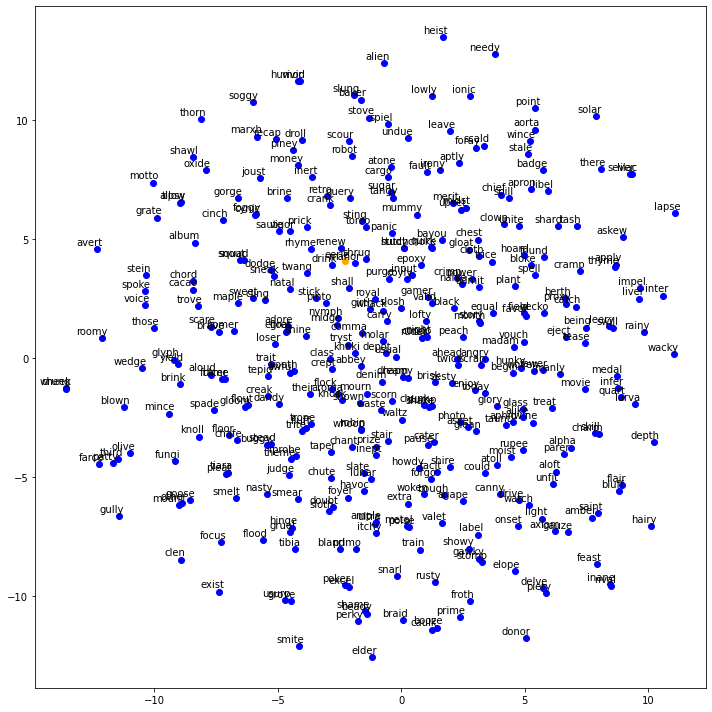

In [20]:
# Use the trained model to classify an unseen word 
unseen_words = np.append(words, 'eerie')
unseen_embed = create_word_embeddings(unseen_words, 100, True, True)

In [21]:
predicted_dist = model.predict(np.array([unseen_embed[-1]]))[0]
predicted_class = np.argmax(predicted_dist)
print(predicted_dist, predicted_class)

1/1 [==============================] - 0s 159ms/step
[0.00440428 0.05647026 0.22739457 0.3331308  0.24241804 0.11039837
 0.02578379] 3
